cuda:0
(497, 400, 400)
(462, 400, 400)
(518, 400, 400)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(504, 400, 400)


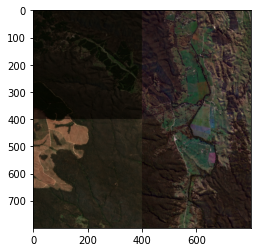

In [3]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class AE(nn.Module):
    def __init__(self, n_comps, n_coeffs):
        super(AE, self).__init__()
        self.n_coeffs = n_coeffs
        self.n_comps = n_comps
        self.D = nn.Linear(1, self.n_comps*404*404, bias=False)
        self.conv1 = nn.Conv2d(self.n_comps, 2*self.n_comps, kernel_size=5, bias=False)
        self.coeffs = nn.Linear(1, 2*self.n_comps*self.n_coeffs, bias=False)
        
    def forward(self, x):
        base = self.D(x)
        conv1 =  torch.tanh(self.conv1(base.reshape(1, self.n_comps, 404, 404)))   
        coeffs = self.coeffs(x).view(2*self.n_comps, self.n_coeffs)
        return torch.einsum('ik,kj->ji', conv1.view(400*400, 2*self.n_comps), coeffs)

input = torch.ones(1, device=device)

net = torch.load("00_00_net.pt")
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load("00_00_mean.npy").reshape(400,400)
print(stack_hat.shape)
top_left = (2*np.dstack((stack_hat[60],stack_hat[71+60],stack_hat[2*71+60])))

net = torch.load("00_01_net.pt")
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load("00_01_mean.npy").reshape(400,400)
print(stack_hat.shape)
bottom_left = (4*np.dstack((stack_hat[60],stack_hat[66+60],stack_hat[2*66+60])))

net = torch.load("01_00_net.pt")
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load("01_00_mean.npy").reshape(400,400)
print(stack_hat.shape)
top_right = (4*np.dstack((stack_hat[60],stack_hat[71+60],stack_hat[2*71+60])))

net = torch.load("01_01_net.pt")
net.eval()

stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load("01_01_mean.npy").reshape(400,400)
print(stack_hat.shape)
bottom_right = (4*np.dstack((stack_hat[60],stack_hat[66+60],stack_hat[2*66+60])))

plt.imshow(np.hstack((np.vstack((top_left,bottom_left)),np.vstack((top_right,bottom_right)))))

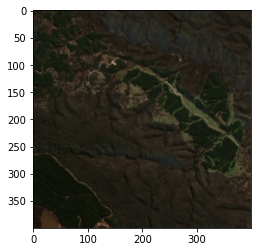

In [11]:
import pandas as pd

i = 0
j = 0
d = 234
b = 0

def retrieve_rgb_image(i,j,d):
    df = pd.DataFrame(data=np.load(f"{j:02d}_{i:02d}_coeffs.npy").reshape(24*7,-1).T, index=np.load(f"{j:02d}_{i:02d}_times.npy"))
    index = pd.date_range('1/1/2018', periods=2*365, freq='D')
    df = df.reindex(index, method='nearest', limit=1).interpolate(method='linear', limit_direction='both')
    coeffs = df.to_numpy().T.flatten()[:,None]

    net = torch.load(f"{j:02d}_{i:02d}_net.pt")

    with torch.no_grad():
        net.coeffs.weight = torch.nn.Parameter(torch.from_numpy(coeffs).to(device))
        net.n_coeffs = 365*2*7

    net.eval()
    stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load(f"{j:02d}_{i:02d}_mean.npy").reshape(400,400)
    
    return np.dstack((stack_hat[d+365*2*0],stack_hat[d+365*2*1],stack_hat[d+365*2*2]))

plt.imshow(4*retrieve_rgb_image(i,j,d))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


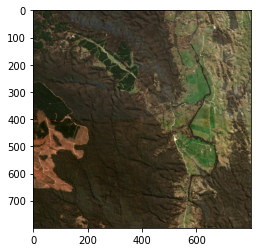

In [16]:
tl = retrieve_rgb_image(0,0,d)
bl = retrieve_rgb_image(1,0,d)
tr = retrieve_rgb_image(0,1,d)
br = retrieve_rgb_image(1,1,d)

plt.imshow(6*np.hstack((np.vstack((tl,bl)),np.vstack((tr,br)))))

In [21]:
i = 0
j = 0
d = 234
b = 0

def retrieve_rgb_image2(i,j,d):
    df = pd.DataFrame(data=np.load(f"{j:02d}_{i:02d}_coeffs.npy").reshape(24*7,-1).T, index=np.load(f"{j:02d}_{i:02d}_times.npy"))
    index = pd.date_range('1/1/2018', periods=2*365, freq='D')
    df = df.reindex(index, method='nearest', limit=1).interpolate(method='linear', limit_direction='both')
    coeffs = df.to_numpy().T[:,d].flatten()[:,None]

    net = torch.load(f"{j:02d}_{i:02d}_net.pt")

    with torch.no_grad():
        net.coeffs.weight = torch.nn.Parameter(torch.from_numpy(coeffs).to(device))
        net.n_coeffs = 7

    net.eval()
    stack_hat = net(input).cpu().detach().numpy().reshape(-1,400,400) + np.load(f"{j:02d}_{i:02d}_mean.npy").reshape(400,400)
    print(stack_hat.shape)
    return np.dstack((stack_hat[0],stack_hat[1],stack_hat[2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(7, 400, 400)
(7, 400, 400)
(7, 400, 400)
(7, 400, 400)


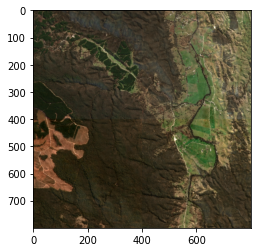

In [22]:
tl = retrieve_rgb_image2(0,0,d)
bl = retrieve_rgb_image2(1,0,d)
tr = retrieve_rgb_image2(0,1,d)
br = retrieve_rgb_image2(1,1,d)

plt.imshow(6*np.hstack((np.vstack((tl,bl)),np.vstack((tr,br)))))